In [2]:
from pathlib import Path
from pandas import Series, DataFrame
from tqdm import tqdm

import imageio
import plotly as plp
import plotly.graph_objs as plgo
import numpy as np
import matplotlib.pyplot as plt
import os.path as op
import cv2
import os
import math
import torch
import torchaudio
import tensorflow as tf

/home/r08922a13/.conda/envs/deepfill/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/r08922a13/.conda/envs/deepfill/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/r08922a13/.conda/envs/deepfill/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/r08922a13/.conda/envs/deepfill/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is depreca

In [3]:
proj_pth = '/work/r08922a13/generative_inpainting'
data_pth = op.join(proj_pth, 'examples/esc50/mag_origin_npy')
os.chdir(proj_pth)

In [ ]:
spec = np.ones([256, 256])
plt.figure()
plt.imshow(spec, 'gray')

In [ ]:
for i, filename in enumerate(sorted(Path(data_pth).glob('*.npy'))):
    print(i, filename)
    
    spec = np.load(filename)
    print(spec.shape)
    h, w, _ = spec.shape
    spec = spec.reshape((h, w))
    print(spec.shape)
    plt.figure()
    plt.imshow(spec, 'gray')
    break

In [ ]:
def l1_loss(x, y):
    error = abs(x - y)
    print(sum(error))
    print(sum(sum(error)))
    return sum(sum(error))

In [ ]:
def psnr(target, ref):
    diff = ref - target
    diff = diff.flatten('C')
    rmse = math.sqrt(np.mean(diff ** 2.))
    return 20 * math.log10(1.0 / rmse)

In [ ]:
def create_mask(length, mask_type='square'):
    # For sorted.
    if length < 10:
        output_pth = op.join(proj_pth, f'examples/esc50/mask_256/mask_{mask_type}_00{length}')
    elif length < 100:
        output_pth = op.join(proj_pth, f'examples/esc50/mask_256/mask_{mask_type}_0{length}')
    else:
        output_pth = op.join(proj_pth, f'examples/esc50/mask_256/mask_{mask_type}_{length}')
    
    if op.isfile(output_pth):
        return output_pth
    
    h, w = spec.shape
    mid_point = h // 2, w // 2
    # print(mid_point, length)
    
    mask = np.zeros((h, w, 3), np.uint8)
    if mask_type == 'square':
        t = mid_point[0] - (length // 2) + 1
        b = mid_point[0] + (length // 2)
        l = mid_point[1] - (length // 2) + 1
        r = mid_point[1] + (length // 2)
        # print(t, b, l, r)
        mask = cv2.rectangle(mask, (l, t), (r, b), (255, 255, 255), -1)
    elif mask_type == 'time':
        area = length * length
        if area < h * 1:
            constant = 11
            height = area // constant
            t = mid_point[0] - (height // 2) + 1
            b = mid_point[0] + (height // 2)
            l = mid_point[1] - (constant // 2) + 1
            r = mid_point[1] + (constant // 2)
        else:
            width = area // h
            t = 0 + 1
            b = h
            l = mid_point[1] - (width // 2) + 1
            r = mid_point[1] + (width // 2)
        # print(t, b, l, r)
        mask = cv2.rectangle(mask, (l, t), (r, b), (255, 255, 255), -1)

    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    # print(gray[110][:])

    plt.figure()
    plt.imshow(mask, 'gray')
    # print(mask[0])

    # This way is for showing the visualized results then convert to 1-channel.
    mask = mask[:, :, np.newaxis]
    # print(square_mask.shape)

    np.save(output_pth, mask)
    return output_pth + '.npy'

In [ ]:
def create_mask_base_on_time(length, mask_type='square'):
    # For sorted.
    if length < 10:
        output_pth = op.join(proj_pth, f'examples/esc50/mask_256/mask_{mask_type}_00{length}')
    elif length < 100:
        output_pth = op.join(proj_pth, f'examples/esc50/mask_256/mask_{mask_type}_0{length}')
    else:
        output_pth = op.join(proj_pth, f'examples/esc50/mask_256/mask_{mask_type}_{length}')
    
    if op.isfile(output_pth):
        return output_pth
    
    h, w = spec.shape
    mid_point = h // 2, w // 2
    # print(mid_point, length)
    
    mask = np.zeros((h, w, 3), np.uint8)
    if mask_type == 'square':
        area = h * length
        side = math.floor(math.sqrt(area))
        t = mid_point[0] - (side // 2) + 1
        b = mid_point[0] + (side // 2)
        l = mid_point[1] - (side // 2) + 1
        r = mid_point[1] + (side // 2)
        # print(t, b, l, r)
        mask = cv2.rectangle(mask, (l, t), (r, b), (255, 255, 255), -1)
    elif mask_type == 'time':
        width = length
        t = 0 + 1
        b = h
        l = mid_point[1] - (width // 2) + 1
        r = mid_point[1] + (width // 2)
        # print(t, b, l, r)
        mask = cv2.rectangle(mask, (l, t), (r, b), (255, 255, 255), -1)

    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    # print(gray[110][:])

    plt.figure()
    plt.imshow(mask, 'gray')
    # print(mask[0])

    # This way is for showing the visualized results then convert to 1-channel.
    mask = mask[:, :, np.newaxis]
    # print(square_mask.shape)

    np.save(output_pth, mask)
    return output_pth + '.npy'

In [ ]:
output_pth = op.join(proj_pth, 'examples/esc50/mag_origin_npy/loss_test_output')
loss_pth = op.join(output_pth, 'l1_loss')
checkpoint = op.join(proj_pth, 'logs/full_model_esc50_origin_npy_test')
square_l1_loss = []
# Set 10 as progress unix for mask length. From 10 -> 400.
for i in range(64):
    image = filename
    
    mask_type = 'square'
    mask_length = (i + 1) * 4
    mask = create_mask_base_on_time(mask_length, mask_type)
    
    #print(op.basename(filename))
    #output_filename = op.basename(filename).split('.')[0] + f'_{mask_type}_{i}' + '.' + op.basename(filename).split('.')[1]
    #output = op.join(output_pth, output_filename)
    #print(output)
    '''
    cmd = f'python /work/r08922a13/generative_inpainting/test.py --image {image} --mask {mask} --output {output} --checkpoint {checkpoint}'
    print(cmd)
    os.system(cmd)
    
    inpaint_spec = np.load(output)
    h, w, _ = inpaint_spec.shape
    inpaint_spec = inpaint_spec.reshape((h, w))

    square_l1_loss.append(l1_loss(spec, inpaint_spec))
    #break
    
loss_filename = op.join(loss_pth, f'l1_loss_{mask_type}.txt')
with open(loss_filename, 'w') as f:
    for index in square_l1_loss:
        f.write(str(index)+'\n')
    '''

In [ ]:
output = '/work/r08922a13/generative_inpainting/examples/esc50/mag_origin_npy/loss_test_output/1-80841-A-13_spec_square_22.npy'
inpaint_spec = np.load(output)
h, w, _ = inpaint_spec.shape
inpaint_spec = inpaint_spec.reshape((h, w))

In [ ]:
loss = psnr(spec, inpaint_spec)
print(loss)

In [ ]:
mask_type = 'square'
loss_filename = op.join(output_pth, f'l1_loss_{mask_type}.txt')
with open(loss_filename, 'r') as f:
    sq_loss_list = f.read().splitlines()
print(sq_loss_list)
square_l1 = [float(i) for i in sq_loss_list]

mask_type = 'time'
loss_filename = op.join(output_pth, f'l1_loss_{mask_type}.txt')
with open(loss_filename, 'r') as f:
    time_loss_list = f.read().splitlines()
print(time_loss_list)
time_l1 = [float(i) for i in time_loss_list]

In [36]:
loss_pth = '/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_output/loss'
loss_trace_list = []
for filename in sorted(Path(loss_pth).glob('*.txt')):
    print(filename)
    sound_name = op.basename(filename).split('.')[0].split('_')[0]
    loss_type = op.basename(filename).split('.')[0].split('_')[2]
    mask_type = op.basename(filename).split('.')[0].split('_')[-1]
    print(sound_name, loss_type, mask_type)
    with open(filename, 'r') as f:
        loss_list = f.read().splitlines()
        loss_list_float = [float(i) for i in loss_list]
        loss_trace_list.append([loss_list_float, sound_name, loss_type, mask_type])

/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_output/loss/1-46353-A-49_2_l1_loss_square.txt
1-46353-A-49 l1 square
/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_output/loss/1-46353-A-49_2_l1_loss_time.txt
1-46353-A-49 l1 time
/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_output/loss/1-46353-A-49_2_mean_l1_loss_square.txt
1-46353-A-49 mean square
/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_output/loss/1-46353-A-49_2_mean_l1_loss_time.txt
1-46353-A-49 mean time
/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_output/loss/1-46353-A-49_2_psnr_loss_square.txt
1-46353-A-49 psnr square
/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_output/loss/1-46353-A-49_2_psnr_loss_time.txt
1-46353-A-49 psnr time
/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_output/loss/4-181628-A-17_3_l1_loss_s

In [27]:
loss_pth = '/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_time_mask_within_v2/loss'
within_loss_trace_list = []
for filename in sorted(Path(loss_pth).glob('*.txt')):
    print(filename)
    sound_name = op.basename(filename).split('.')[0].split('_')[0]
    loss_type = op.basename(filename).split('.')[0].split('_')[2]
    mask_type = op.basename(filename).split('.')[0].split('_')[-1]
    print(sound_name, loss_type, mask_type)
    with open(filename, 'r') as f:
        loss_list = f.read().splitlines()
        loss_list_float = [float(i) for i in loss_list]
        within_loss_trace_list.append([loss_list_float, sound_name, loss_type, mask_type])

/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_time_mask_within_v2/loss/1-46353-A-49_2_l1_loss_square.txt
1-46353-A-49 l1 square
/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_time_mask_within_v2/loss/1-46353-A-49_2_l1_loss_time.txt
1-46353-A-49 l1 time
/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_time_mask_within_v2/loss/1-46353-A-49_2_mean_l1_loss_square.txt
1-46353-A-49 mean square
/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_time_mask_within_v2/loss/1-46353-A-49_2_mean_l1_loss_time.txt
1-46353-A-49 mean time
/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_time_mask_within_v2/loss/1-46353-A-49_2_psnr_loss_square.txt
1-46353-A-49 psnr square
/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_time_mask_within_v2/loss/1-46353-A-49_2_psnr_loss_time.txt
1-46353-A-49 psnr time
/work/r08922a13/generative_inpaintin

In [28]:
loss_pth = '/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_time_mask_only/loss'
only_loss_trace_list = []
for filename in sorted(Path(loss_pth).glob('*.txt')):
    print(filename)
    sound_name = op.basename(filename).split('.')[0].split('_')[0]
    loss_type = op.basename(filename).split('.')[0].split('_')[2]
    mask_type = op.basename(filename).split('.')[0].split('_')[-1]
    print(sound_name, loss_type, mask_type)
    with open(filename, 'r') as f:
        loss_list = f.read().splitlines()
        loss_list_float = [float(i) for i in loss_list]
        only_loss_trace_list.append([loss_list_float, sound_name, loss_type, mask_type])

/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_time_mask_only/loss/1-46353-A-49_2_l1_loss_square.txt
1-46353-A-49 l1 square
/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_time_mask_only/loss/1-46353-A-49_2_l1_loss_time.txt
1-46353-A-49 l1 time
/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_time_mask_only/loss/1-46353-A-49_2_mean_l1_loss_square.txt
1-46353-A-49 mean square
/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_time_mask_only/loss/1-46353-A-49_2_mean_l1_loss_time.txt
1-46353-A-49 mean time
/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_time_mask_only/loss/1-46353-A-49_2_psnr_loss_square.txt
1-46353-A-49 psnr square
/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_time_mask_only/loss/1-46353-A-49_2_psnr_loss_time.txt
1-46353-A-49 psnr time
/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256

In [33]:
loss_pth = '/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_time_wider/loss'
wider_loss_trace_list = []
for filename in sorted(Path(loss_pth).glob('*.txt')):
    print(filename)
    sound_name = op.basename(filename).split('.')[0].split('_')[0]
    loss_type = op.basename(filename).split('.')[0].split('_')[2]
    mask_type = op.basename(filename).split('.')[0].split('_')[-1]
    print(sound_name, loss_type, mask_type)
    with open(filename, 'r') as f:
        loss_list = f.read().splitlines()
        loss_list_float = [float(i) for i in loss_list]
        wider_loss_trace_list.append([loss_list_float, sound_name, loss_type, mask_type])

/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_time_wider/loss/1-46353-A-49_2_l1_loss_square.txt
1-46353-A-49 l1 square
/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_time_wider/loss/1-46353-A-49_2_l1_loss_time.txt
1-46353-A-49 l1 time
/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_time_wider/loss/1-46353-A-49_2_mean_l1_loss_square.txt
1-46353-A-49 mean square
/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_time_wider/loss/1-46353-A-49_2_mean_l1_loss_time.txt
1-46353-A-49 mean time
/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_time_wider/loss/1-46353-A-49_2_psnr_loss_square.txt
1-46353-A-49 psnr square
/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_time_wider/loss/1-46353-A-49_2_psnr_loss_time.txt
1-46353-A-49 psnr time
/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_time_wider/lo

In [34]:
loss_pth = '/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_time_wider_l115/loss'
wider_l115_loss_trace_list = []
for filename in sorted(Path(loss_pth).glob('*.txt')):
    print(filename)
    sound_name = op.basename(filename).split('.')[0].split('_')[0]
    loss_type = op.basename(filename).split('.')[0].split('_')[2]
    mask_type = op.basename(filename).split('.')[0].split('_')[-1]
    print(sound_name, loss_type, mask_type)
    with open(filename, 'r') as f:
        loss_list = f.read().splitlines()
        loss_list_float = [float(i) for i in loss_list]
        wider_l115_loss_trace_list.append([loss_list_float, sound_name, loss_type, mask_type])

/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_time_wider_l115/loss/1-46353-A-49_2_l1_loss_square.txt
1-46353-A-49 l1 square
/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_time_wider_l115/loss/1-46353-A-49_2_l1_loss_time.txt
1-46353-A-49 l1 time
/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_time_wider_l115/loss/1-46353-A-49_2_mean_l1_loss_square.txt
1-46353-A-49 mean square
/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_time_wider_l115/loss/1-46353-A-49_2_mean_l1_loss_time.txt
1-46353-A-49 mean time
/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_time_wider_l115/loss/1-46353-A-49_2_psnr_loss_square.txt
1-46353-A-49 psnr square
/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_time_wider_l115/loss/1-46353-A-49_2_psnr_loss_time.txt
1-46353-A-49 psnr time
/work/r08922a13/generative_inpainting/examples/esc50/mag_seg

In [ ]:
err_pth = '/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_output/audio/loss'
err_trace_list = []
for filename in sorted(Path(err_pth).glob('*.txt')):
    print(filename)
    sound_name = op.basename(filename).split('.')[0].split('_')[0]
    mask_type = op.basename(filename).split('.')[0].split('_')[-2]
    error_type = op.basename(filename).split('.')[0].split('_')[-1]
    print(sound_name, error_type, mask_type)
    with open(filename, 'r') as f:
        err_list = f.read().splitlines()
        err_list_float = [float(i) for i in err_list]
        err_trace_list.append([err_list_float, sound_name, error_type, mask_type])

In [7]:
area_list = []
for i in range(64):
    length = (i+1) * 4
    area_list.append(length)
print(area_list)
area_list = np.array(area_list)

[4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252, 256]


In [ ]:
square_l1_np = np.array(square_l1)
square_l1_around = np.around(square_l1_np, decimals=1)
print(square_l1_around)
square_l1_1f = ["{:0.1f}".format(v) for v in square_l1_around]
print(square_l1_1f)

time_l1_np = np.array(time_l1)
time_l1_around = np.around(time_l1_np, decimals=1)
print(time_l1_around)
time_l1_1f = ["{:0.1f}".format(v) for v in time_l1_around]
print(time_l1_1f)

In [25]:
# loss_trace_list = err_trace_list # Enable if testing the error on waveform
set_num = 3
trace01, name01, loss01, mask01 = loss_trace_list[set_num * 2]
trace02, name02, loss02, mask02 = loss_trace_list[set_num * 2 + 1]
if loss01 == 'mean': loss01 = 'mean L1'
print(trace01, name01, loss01, mask01)
print(trace02, name02, loss02, mask02)
trace_1 = plgo.Scatter(x=area_list, y=trace01, mode='markers', name=mask01)
trace_2 = plgo.Scatter(x=area_list, y=trace02, mode='markers', name=mask02)
data = [trace_1, trace_2]
layout = plgo.Layout(
    xaxis={'title':f'length ({name01})', 'titlefont':{'size':15}},
    yaxis={'title':f'loss ({loss01})', 'titlefont':{'size':15}})
fig = plgo.Figure(data=data, layout=layout)
plp.offline.iplot(fig, filename=loss01)

[0.029890595003962517, 0.029843978583812714, 0.030346179381012917, 0.02951483428478241, 0.029690375551581383, 0.028339555487036705, 0.029627839103341103, 0.030285976827144623, 0.030413616448640823, 0.03057980164885521, 0.02962384931743145, 0.030434677377343178, 0.030642792582511902, 0.030638469383120537, 0.029133561998605728, 0.028941212221980095, 0.029930101707577705, 0.028413331136107445, 0.030789019539952278, 0.029003623872995377, 0.02898317761719227, 0.03006279654800892, 0.02895980142056942, 0.02982068993151188, 0.03068501129746437, 0.030037732794880867, 0.030421976000070572, 0.028907248750329018, 0.02865717001259327, 0.029181279242038727, 0.02792774699628353, 0.028687145560979843, 0.030293943360447884, 0.03178989142179489, 0.03258565068244934, 0.030421284958720207, 0.03067873604595661, 0.029939737170934677, 0.031663015484809875, 0.03138723969459534, 0.03292345628142357, 0.03406040370464325, 0.0343625582754612, 0.021967338398098946, 0.021967338398098946, 0.021967338398098946, 0.021

In [45]:
set_num = 10
constant = 1 # time = 1, square = 0
trace01, name01, loss01, mask01 = loss_trace_list[set_num * 2 + constant]
trace02, name02, loss02, mask02 = within_loss_trace_list[set_num * 2 + constant]
trace03, name03, loss03, mask03 = only_loss_trace_list[set_num * 2 + constant]
trace04, name04, loss04, mask04 = wider_loss_trace_list[set_num * 2 + constant]
trace05, name05, loss05, mask05 = wider_l115_loss_trace_list[set_num * 2 + constant]
if loss01 == 'mean': loss01 = 'mean L1'
print(trace01, name01, loss01, mask01)
print(trace02, name02, loss02, mask02)
print(trace03, name03, loss03, mask03)
print(trace04, name04, loss04, mask04)
print(trace05, name05, loss05, mask05)
trace_1 = plgo.Scatter(x=area_list, y=trace01, mode='markers', name='rect')
trace_2 = plgo.Scatter(x=area_list, y=trace02, mode='markers', name='within')
trace_3 = plgo.Scatter(x=area_list, y=trace03, mode='markers', name='time')
trace_4 = plgo.Scatter(x=area_list, y=trace04, mode='markers', name='wider')
trace_5 = plgo.Scatter(x=area_list, y=trace05, mode='markers', name='widerl1up')
data = [trace_1, trace_2, trace_3, trace_4, trace_5]
layout = plgo.Layout(
    xaxis={'title':f'length ({name01})', 'titlefont':{'size':15}},
    yaxis={'title':f'loss ({loss01})', 'titlefont':{'size':15}})
fig = plgo.Figure(data=data, layout=layout)
plp.offline.iplot(fig, filename=loss01)

[0.00048802973, 0.0010541473, 0.002004101, 0.002651754, 0.0032436592, 0.0039264704, 0.0046234056, 0.005341969, 0.0059131654, 0.0065814657, 0.007140864, 0.007822522, 0.008464384, 0.009141851, 0.009744986, 0.010363761, 0.010935177, 0.011622179, 0.012235912, 0.012963958, 0.013603298, 0.014179008, 0.01484651, 0.015667614, 0.016105417, 0.016253049, 0.017511707, 0.018678311, 0.020064158, 0.021820009, 0.023305835, 0.023978688, 0.025381787, 0.026646385, 0.027821245, 0.028648723, 0.029416187, 0.030185588, 0.031328674, 0.032458536, 0.03305585, 0.034009766, 0.034715258, 0.03569327, 0.036870938, 0.037969694, 0.038706426, 0.039628223, 0.039939865, 0.04093676, 0.04170285, 0.042908125, 0.0422112, 0.042981245, 0.0436304, 0.0450808, 0.044475213, 0.046063587, 0.047781516, 0.05016181, 0.0547721, 0.05649015, 0.058241006, 0.07320919] 4-90014-B-42 mean L1 time
[0.00049212994, 0.0009812166, 0.0017578047, 0.0024900322, 0.0031255148, 0.0037866835, 0.0044767135, 0.005129373, 0.0057038236, 0.0063602757, 0.007013

In [ ]:
loss_trace_list = err_trace_list # Enable if testing the error on waveform
set_num = 10
trace01, name01, loss01, mask01 = loss_trace_list[set_num * 2]
trace02, name02, loss02, mask02 = loss_trace_list[set_num * 2 + 1]
if loss01 == 'mean': loss01 = 'mean L1'
print(trace01, name01, loss01, mask01)
print(trace02, name02, loss02, mask02)
trace_1 = plgo.Scatter(x=area_list, y=trace01, mode='markers', name=mask01)
trace_2 = plgo.Scatter(x=area_list, y=trace02, mode='markers', name=mask02)
data = [trace_1, trace_2]
layout = plgo.Layout(
    xaxis={'title':f'length ({name01})', 'titlefont':{'size':15}},
    yaxis={'title':f'loss ({loss01})', 'titlefont':{'size':15}})
fig = plgo.Figure(data=data, layout=layout)
plp.offline.iplot(fig, filename=loss01)

In [ ]:
trace_0 = plgo.Scatter(x=area_list, y=square_l1_1f, mode='markers', name='square mask')
trace_1 = plgo.Scatter(x=area_list, y=time_l1_1f, mode='markers', name='time mask')
data = [trace_0, trace_1]
layout = plgo.Layout(
    xaxis={'title':'length', 'titlefont':{'size':20}},
    yaxis={'title':'loss (l1)', 'titlefont':{'size':20}})
fig = plgo.Figure(data=data, layout=layout)
plp.offline.iplot(fig, filename='loss')

In [ ]:
data = np.stack((area_list, time_l1_1f))
print(data, data.shape)

plt.figure()
plt.ylabel('l1loss')
plt.xlabel('length')
plt.plot(area_list, time_l1_1f, 'k', linestyle='dashed', marker='o')

In [4]:
data_pth = op.join(proj_pth, 'examples/esc50/mag_seg15_256/')
png_pth = op.join(proj_pth, 'examples/esc50/mag_seg15_256/loss_test_time_mask_only/audio/png')
shape = ['square', 'time']
for filename in sorted(Path(data_pth).glob('*.npy')):
    #print(filename)
    file = op.basename(filename).split('.')[0]
    for anyshape in shape:
        #print(file, anyshape)
        file_shape = file + '_' + anyshape
        print(file_shape)
        with imageio.get_writer(op.join(png_pth, f'{file_shape}.gif'), mode='I', duration=0.2) as writer:
            for png in tqdm(sorted(Path(png_pth).glob(f'{file_shape}*.png'))):
                # print(png)
                image = imageio.imread(png)
                #plt.figure()
                #plt.imshow(image, 'gray')
                writer.append_data(image)
'''
mask_pth = op.join(proj_pth, 'examples/esc50/mag_seg15_256/loss_test_output/png')
with imageio.get_writer(op.join(mask_pth, '../mask_square.gif'), mode='I', duration=0.2) as writer:
    for png in sorted(Path(mask_pth).glob('mask_square*')):
        print(png)
        image = imageio.imread(png)
        #plt.figure()
        #plt.imshow(image, 'gray')
        writer.append_data(image)
'''

  5%|▍         | 3/64 [00:00<00:02, 27.11it/s]

1-46353-A-49_2_square


  8%|▊         | 5/64 [00:00<00:01, 40.57it/s]

1-46353-A-49_2_time


  8%|▊         | 5/64 [00:00<00:01, 36.14it/s]

4-181628-A-17_3_square


  3%|▎         | 2/64 [00:00<00:03, 19.56it/s]

4-181628-A-17_3_time


  6%|▋         | 4/64 [00:00<00:01, 34.32it/s]

4-185575-C-20_2_square


  5%|▍         | 3/64 [00:00<00:02, 27.08it/s]

4-185575-C-20_2_time


  5%|▍         | 3/64 [00:00<00:02, 26.66it/s]

4-90014-B-42_3_square


  8%|▊         | 5/64 [00:00<00:01, 42.31it/s]

4-90014-B-42_3_time


100%|██████████| 64/64 [00:01<00:00, 35.09it/s]


"\nmask_pth = op.join(proj_pth, 'examples/esc50/mag_seg15_256/loss_test_output/png')\nwith imageio.get_writer(op.join(mask_pth, '../mask_square.gif'), mode='I', duration=0.2) as writer:\n    for png in sorted(Path(mask_pth).glob('mask_square*')):\n        print(png)\n        image = imageio.imread(png)\n        #plt.figure()\n        #plt.imshow(image, 'gray')\n        writer.append_data(image)\n"

In [47]:
# diff -> png -> gif
data_pth = op.join(proj_pth, 'examples/esc50/mag_seg15_256/')
output_pth = op.join(proj_pth, 'examples/esc50/mag_seg15_256/loss_test_time_wider')
diff_pth = op.join(output_pth, 'diff_output')
if op.isdir(diff_pth) is False:
    os.mkdir(diff_pth)
shape = ['square', 'time']
for filename in sorted(Path(data_pth).glob('*.npy')):
    origin = np.load(filename)
    file = op.basename(filename).split('.')[0]
    for anyshape in shape:
        file_shape = file + '_' + anyshape
        for output in tqdm(sorted(Path(output_pth).glob(f'{file_shape}*.npy'))):
            #print(output)
            inpainted = np.load(output)
            diff = abs(inpainted - origin)
            diff_output = op.join(diff_pth, op.basename(output))
            #print(diff_output)
            np.save(diff_output, diff)

png_pth = op.join(diff_pth, 'png')
if op.isdir(png_pth) is False:
    os.mkdir(png_pth)
for i, filename in enumerate(sorted(Path(output_pth).glob('*.npy'))):
    print(i, filename)
    
    spec = np.load(filename)
    h, w, _ = spec.shape
    spec = spec.reshape((h, w))
    
    png_filename = op.basename(filename).split('.')[0] + '.png'
    png_filename = op.join(png_pth, png_filename)
    
    # First save the spec to png with force try.
    plt.imsave(png_filename, spec, cmap='gray')


for filename in sorted(Path(data_pth).glob('*.npy')):
    #print(filename)
    file = op.basename(filename).split('.')[0]
    for anyshape in shape:
        #print(file, anyshape)
        file_shape = file + '_' + anyshape
        print(file_shape)
        with imageio.get_writer(op.join(png_pth, f'{file_shape}.gif'), mode='I', duration=0.2) as writer:
            for png in tqdm(sorted(Path(png_pth).glob(f'{file_shape}*.png'))):
                # print(png)
                image = imageio.imread(png)
                #plt.figure()
                #plt.imshow(image, 'gray')
                writer.append_data(image)

100%|██████████| 64/64 [00:00<00:00, 87.89it/s] 


In [53]:
# diff -> png -> gif
data_pth = op.join(proj_pth, 'examples/esc50/mag_seg15_256/')
output_pth = op.join(proj_pth, 'examples/esc50/mag_seg15_256/loss_test_time_wider_l115')
png_pth = op.join(output_pth, 'png')
shape = ['square', 'time']
if op.isdir(png_pth) is False:
    os.mkdir(png_pth)
for i, filename in tqdm(enumerate(sorted(Path(output_pth).glob('*.npy')))):
    # print(i, filename)
    
    spec = np.load(filename)
    h, w, _ = spec.shape
    spec = spec.reshape((h, w))
    
    png_filename = op.basename(filename).split('.')[0] + '.png'
    png_filename = op.join(png_pth, png_filename)
    
    # First save the spec to png with force try.
    plt.imsave(png_filename, spec, cmap='gray')


for filename in sorted(Path(data_pth).glob('*.npy')):
    #print(filename)
    file = op.basename(filename).split('.')[0]
    for anyshape in shape:
        #print(file, anyshape)
        file_shape = file + '_' + anyshape
        # print(file_shape)
        with imageio.get_writer(op.join(png_pth, f'{file_shape}.gif'), mode='I', duration=0.2) as writer:
            for png in tqdm(sorted(Path(png_pth).glob(f'{file_shape}*.png'))):
                # print(png)
                image = imageio.imread(png)
                #plt.figure()
                #plt.imshow(image, 'gray')
                writer.append_data(image)

512it [00:10, 46.60it/s]
100%|██████████| 64/64 [00:00<00:00, 128.53it/s]


 31%|███▏      | 20/64 [00:02<00:06,  6.74it/s]/home/r08922a13/.conda/envs/deepfill/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

 59%|█████▉    | 38/64 [00:04<00:03,  8.24it/s]


KeyboardInterrupt: 

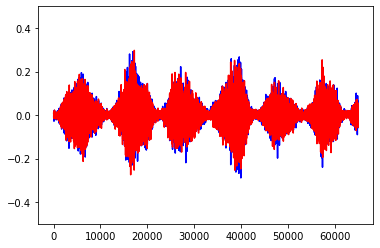

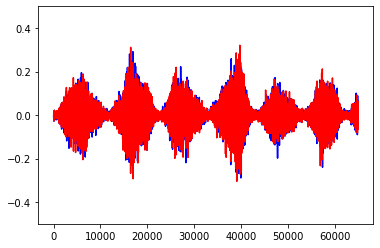

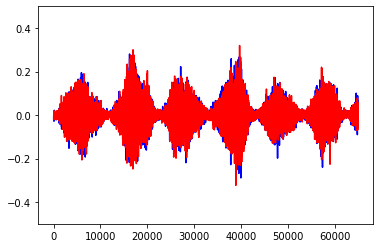

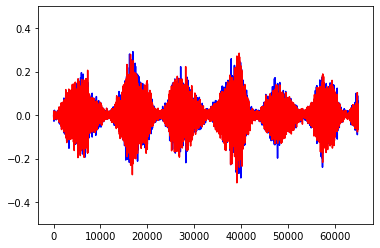

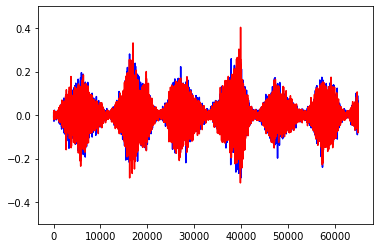

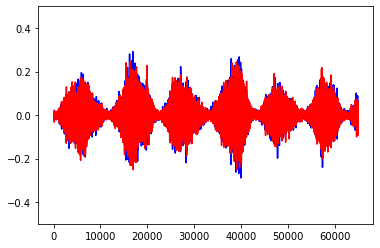

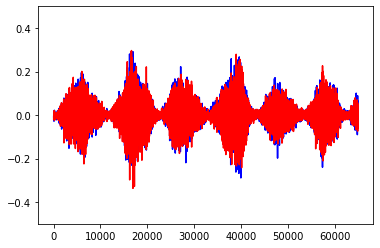

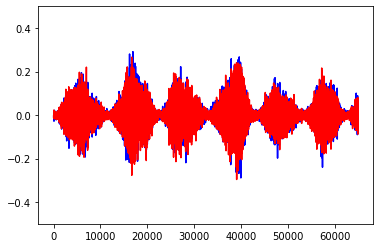

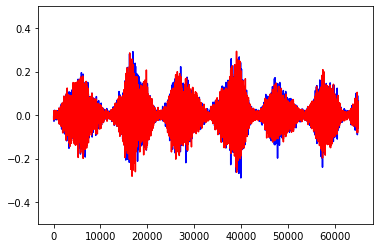

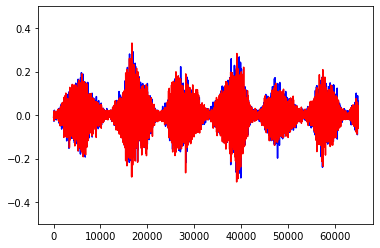

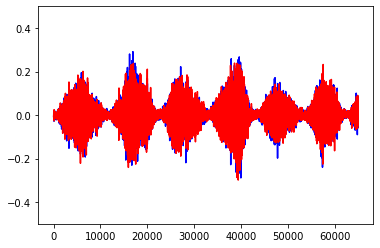

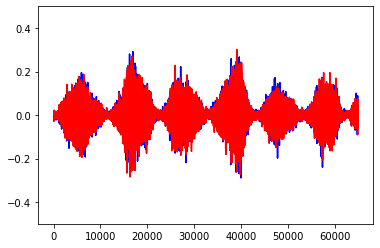

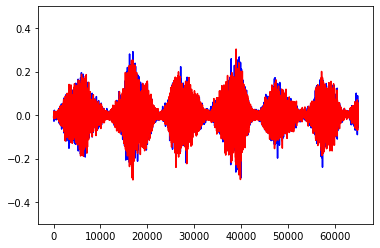

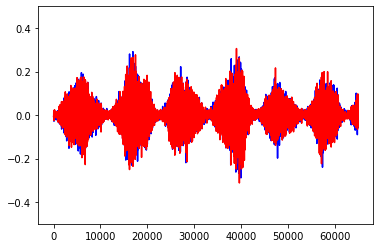

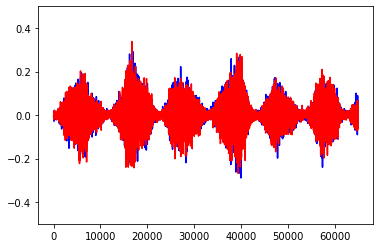

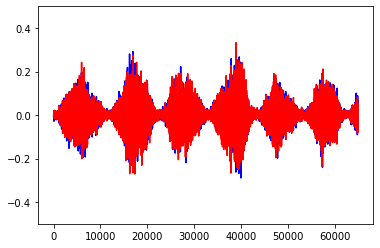

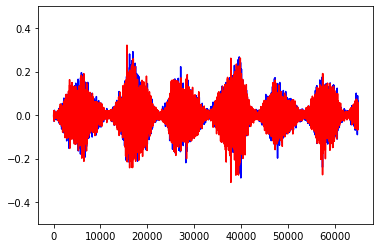

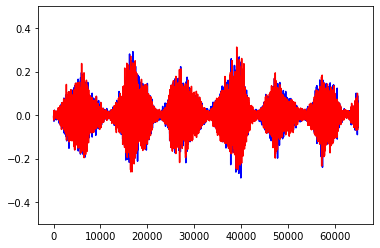

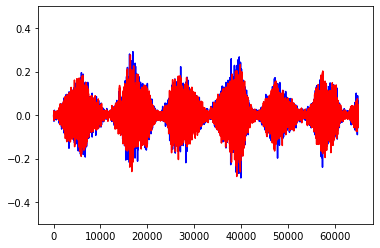

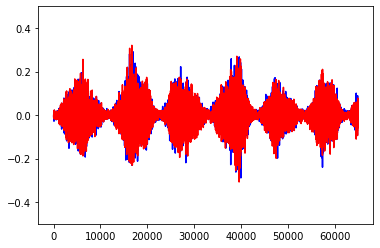

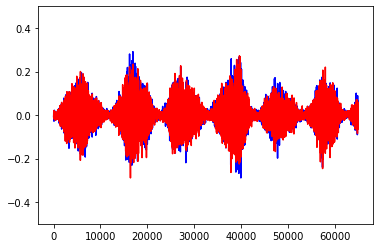

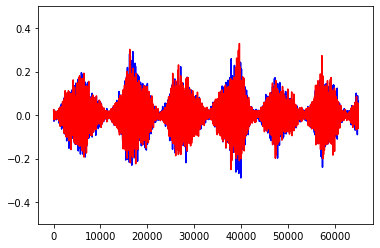

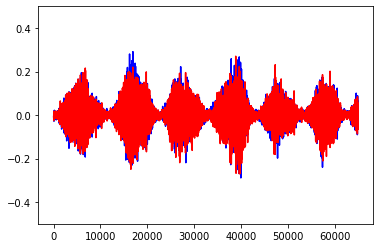

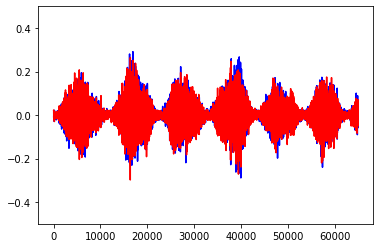

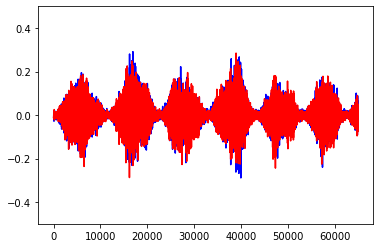

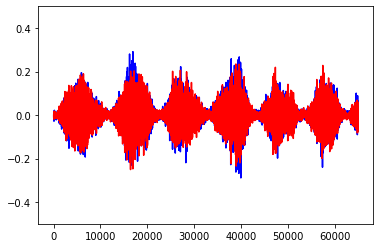

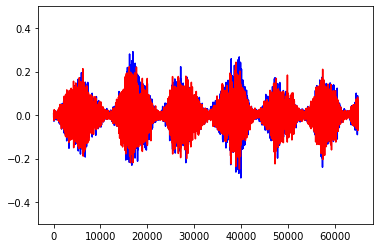

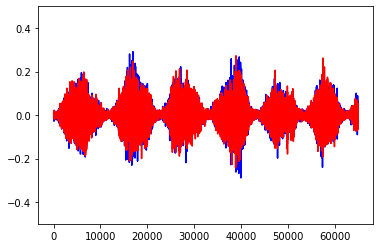

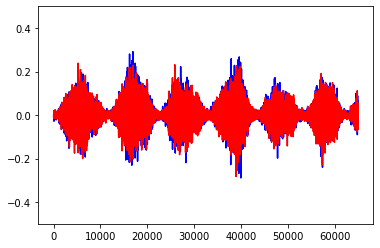

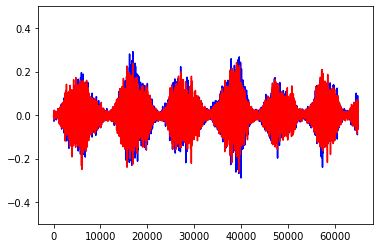

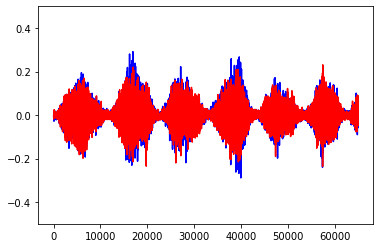

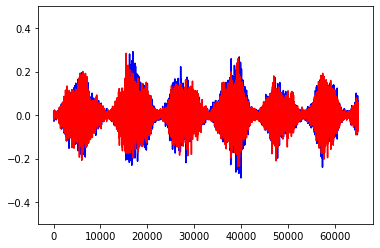

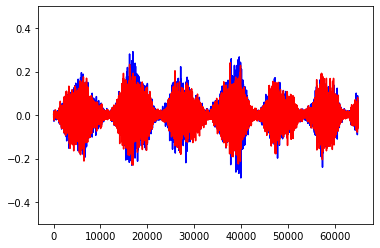

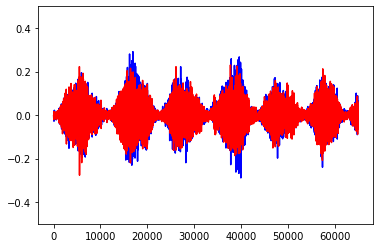

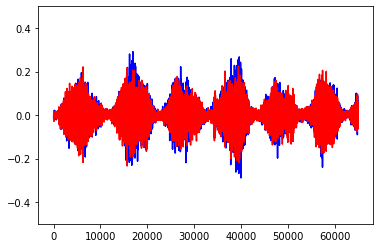

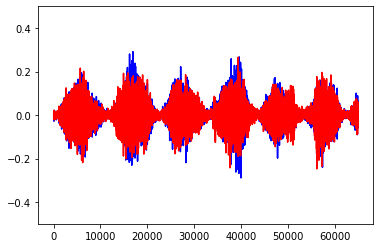

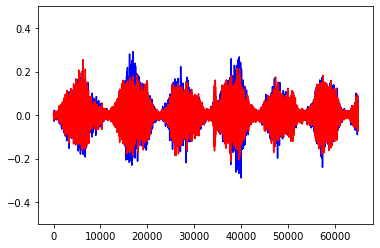

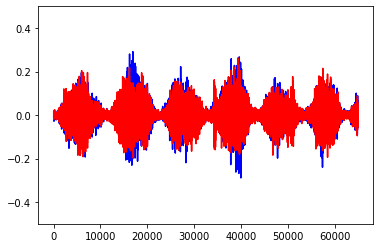

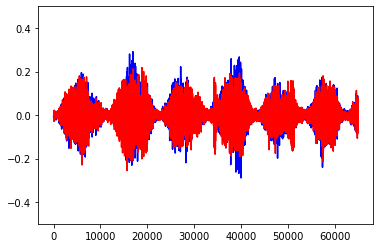

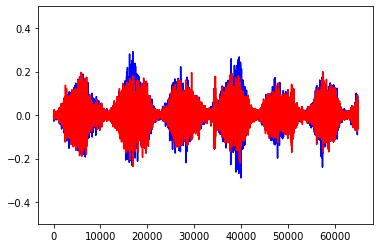

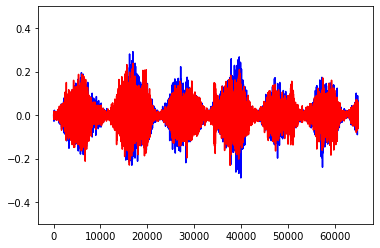

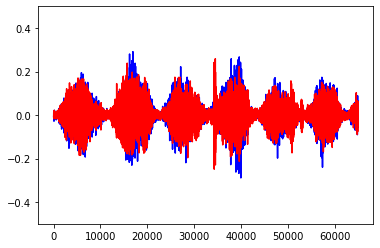

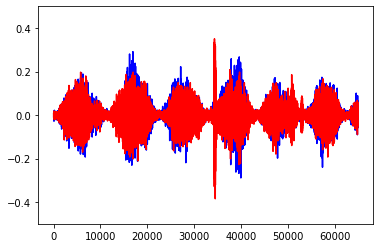

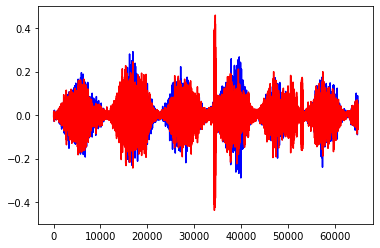

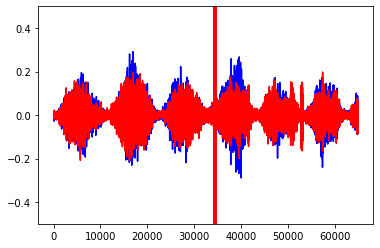

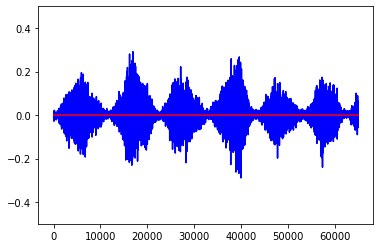

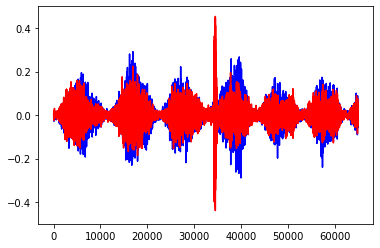

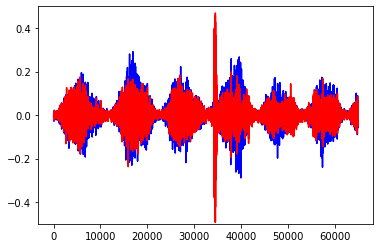

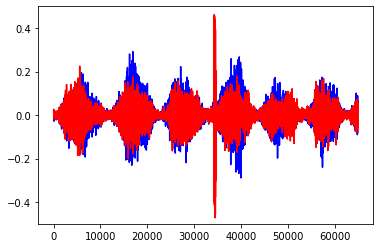

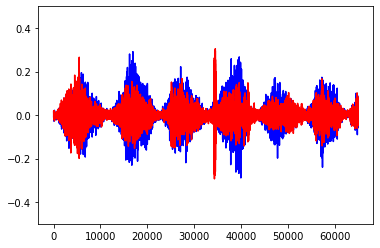

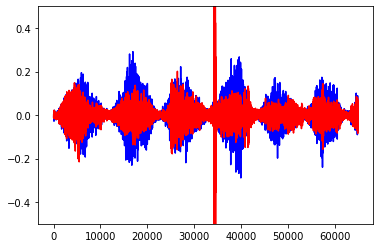

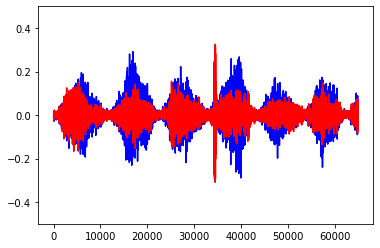

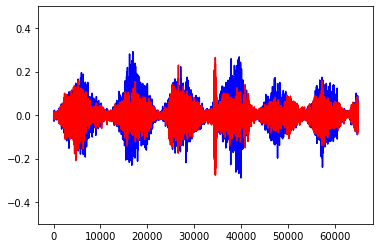

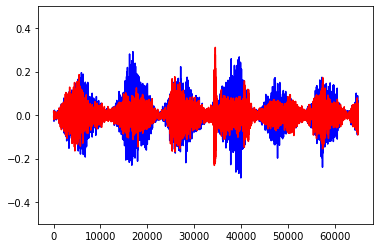

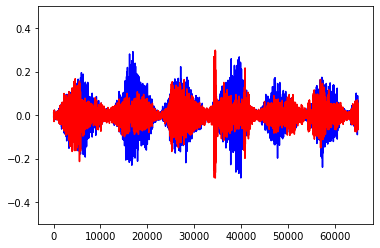

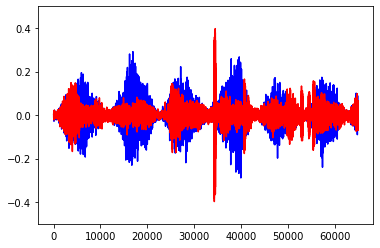

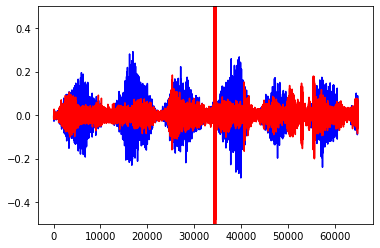

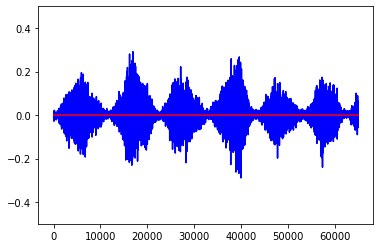

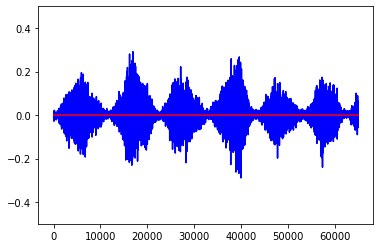

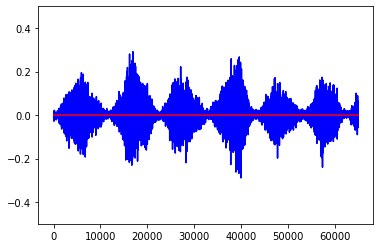

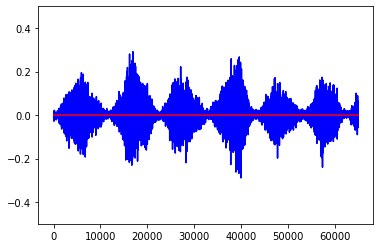

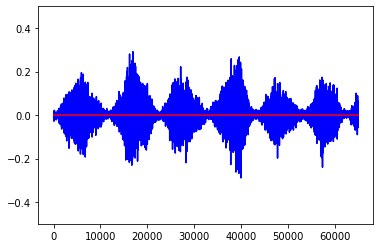

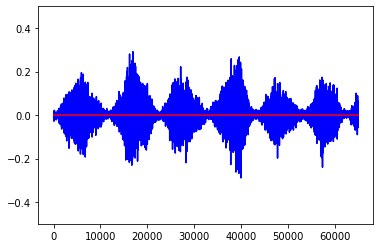

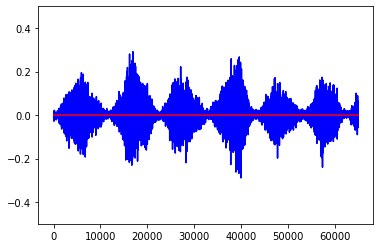

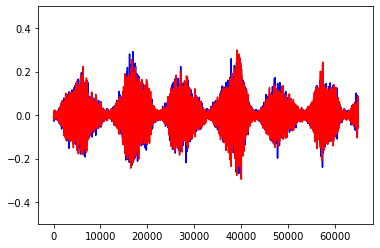

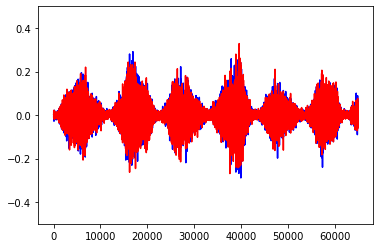

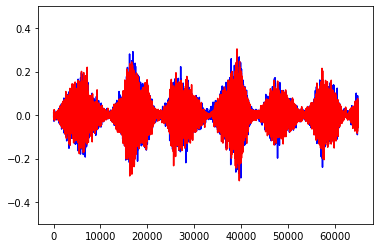

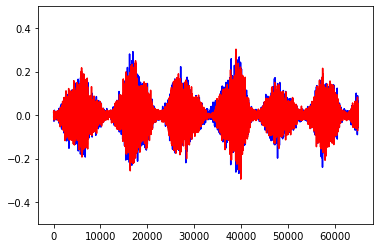

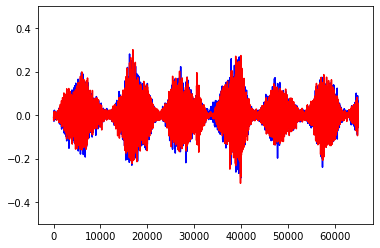

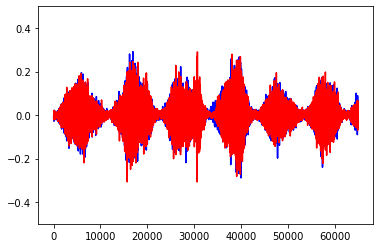

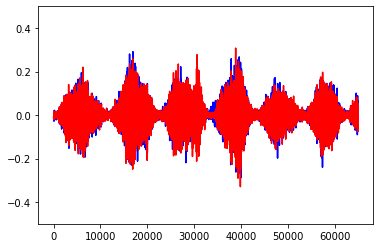

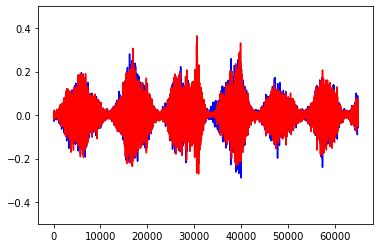

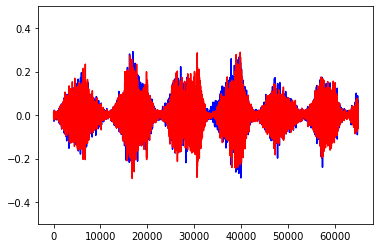

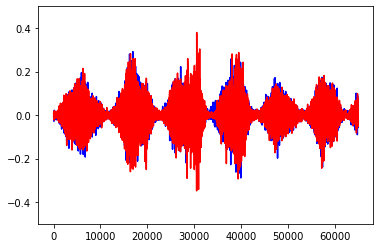

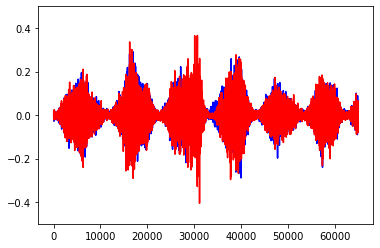

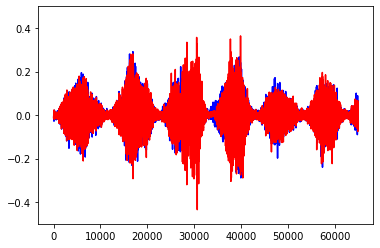

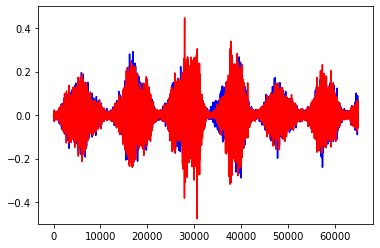

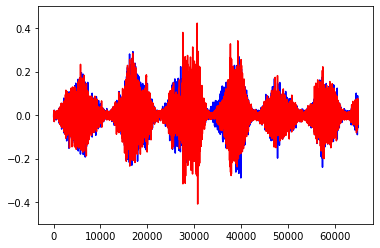

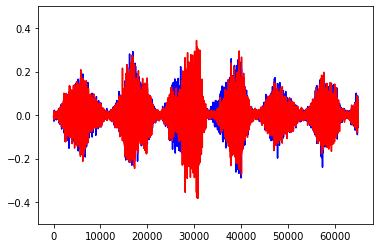

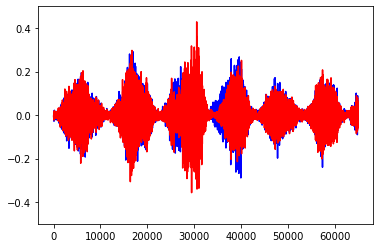

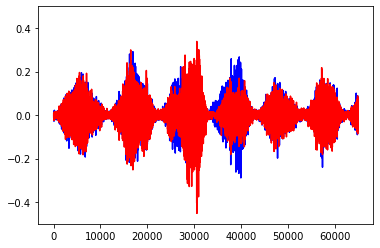

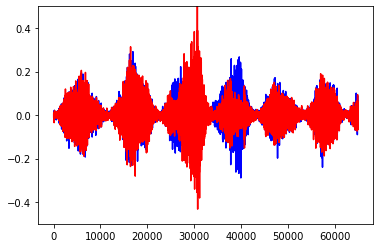

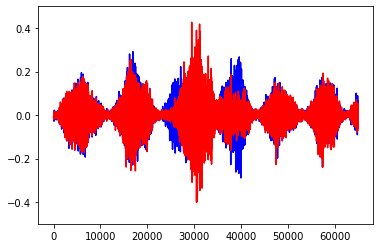

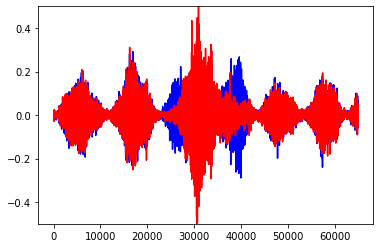

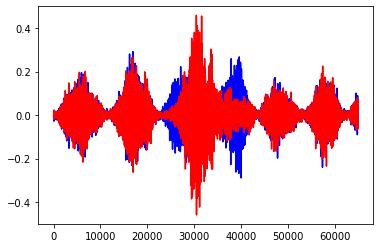

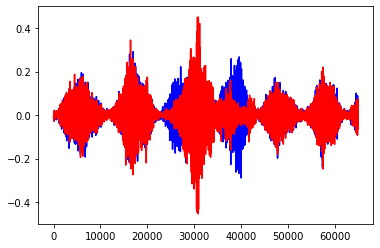

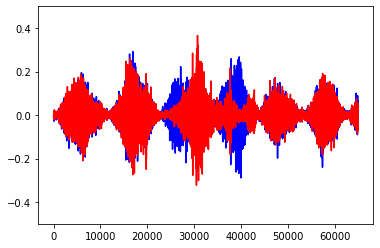

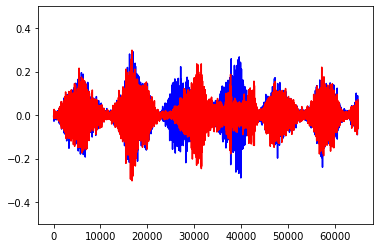

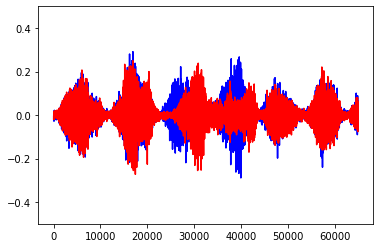

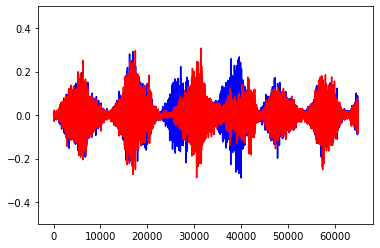

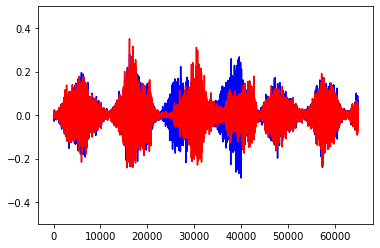

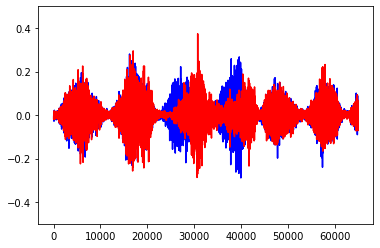

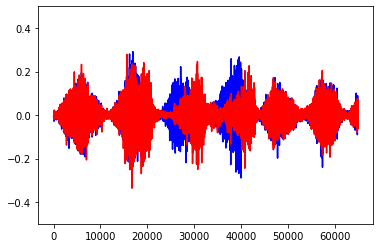

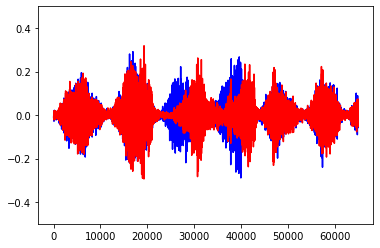

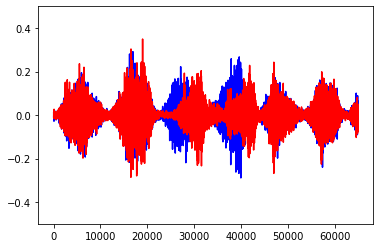

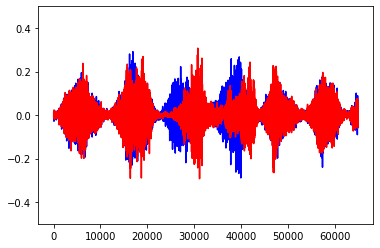

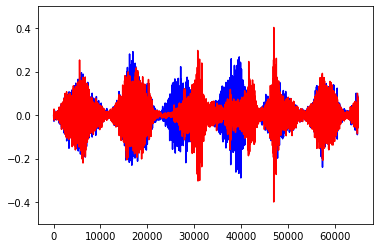

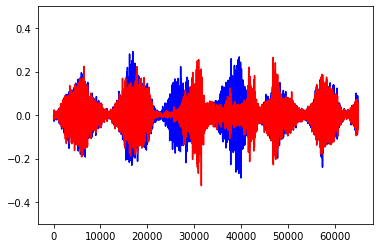

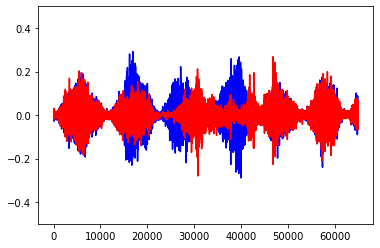

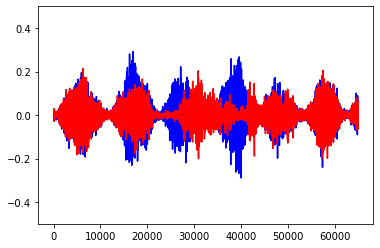

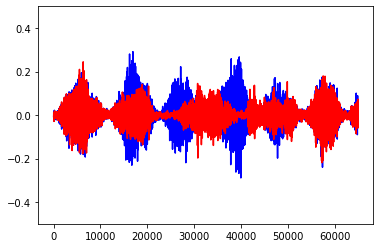

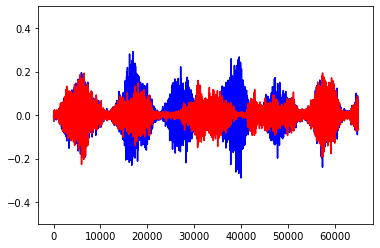

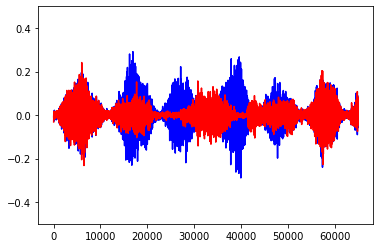

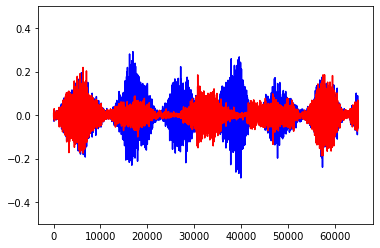

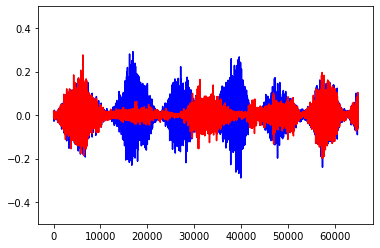

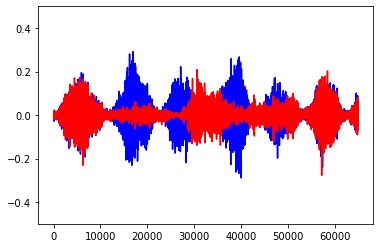

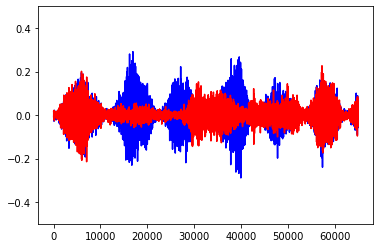

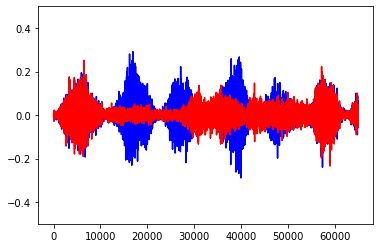

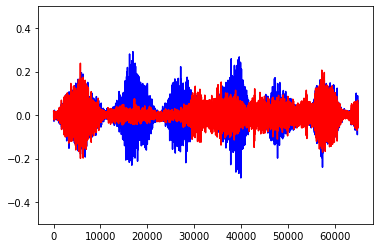

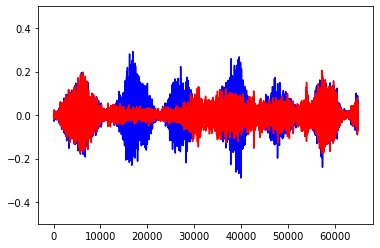

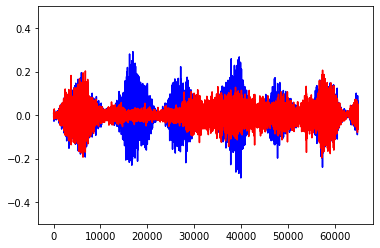

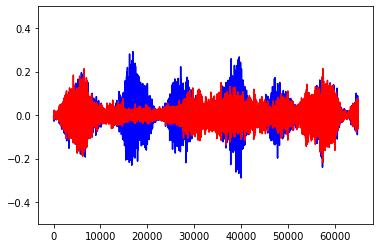

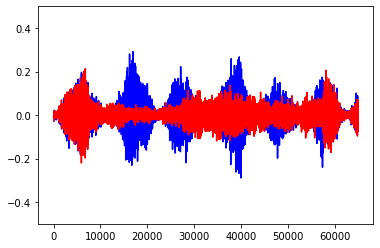

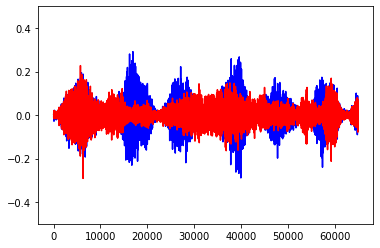

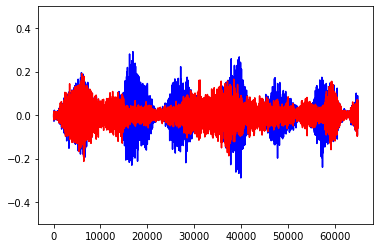

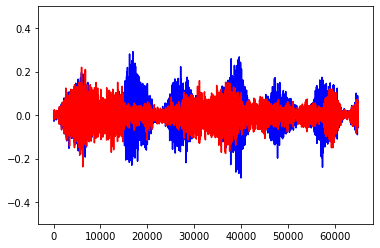

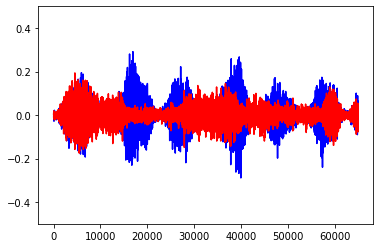

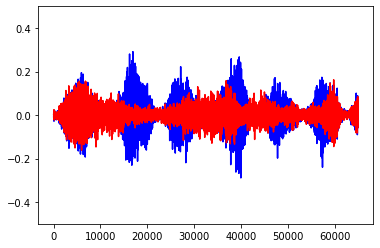

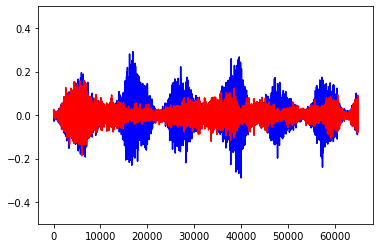

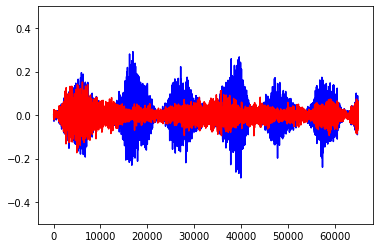

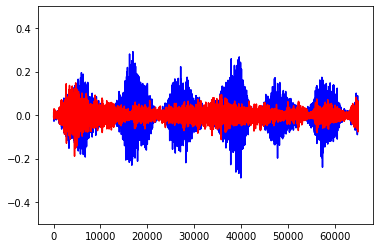

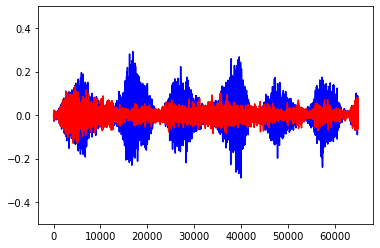

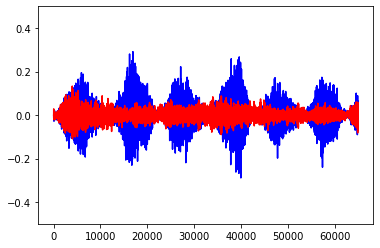

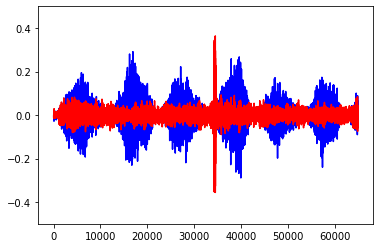

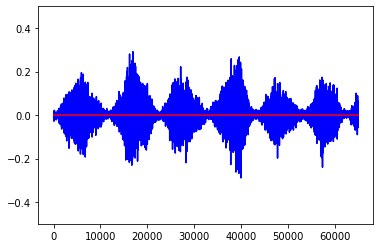

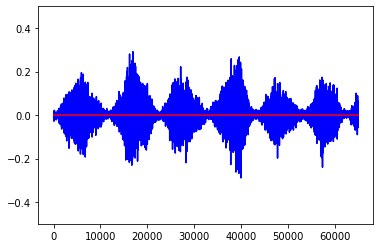

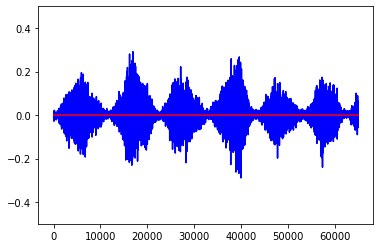

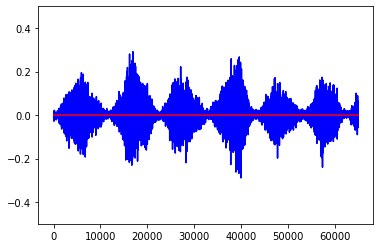

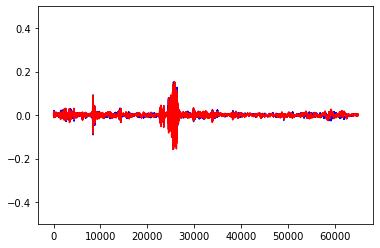

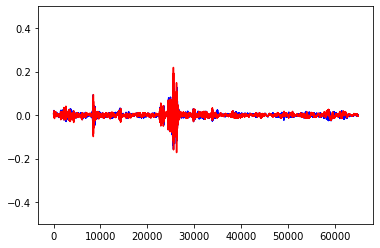

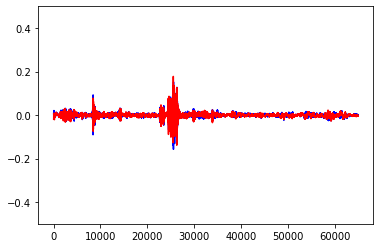

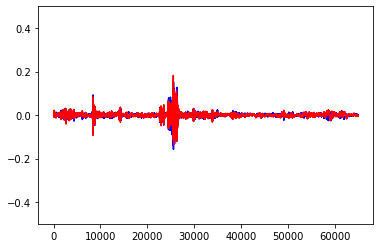

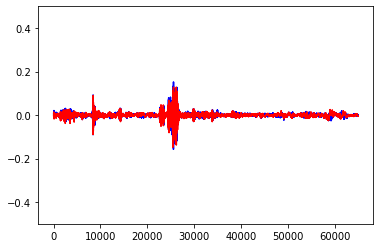

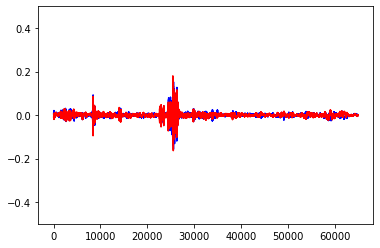

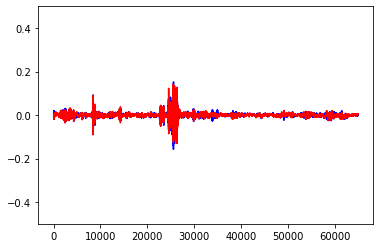

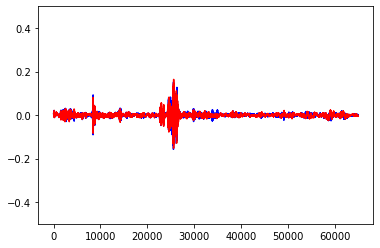

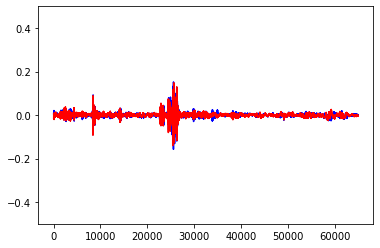

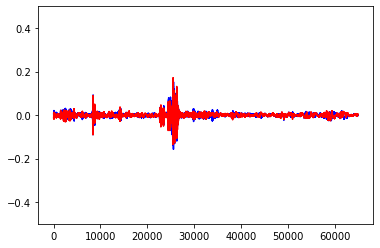

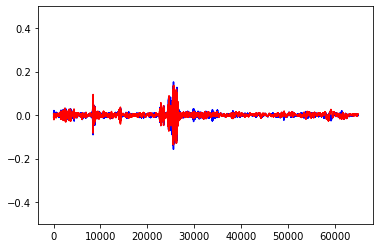

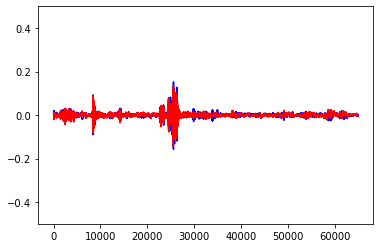

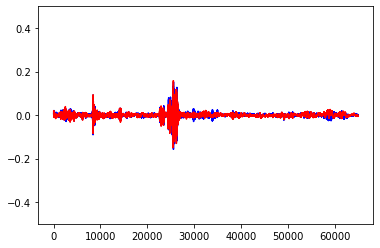

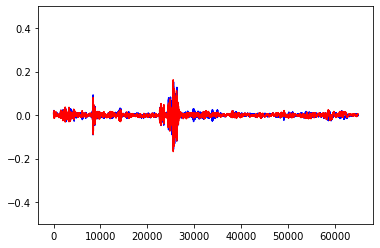

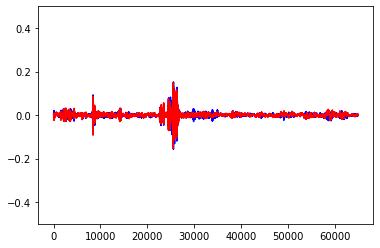

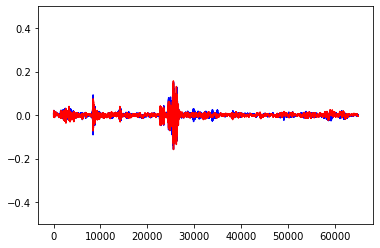

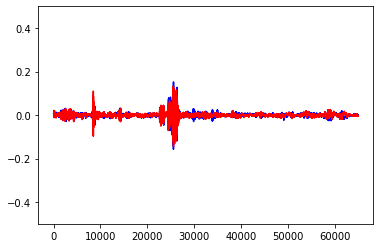

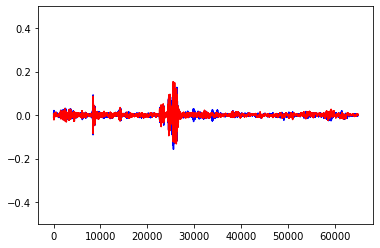

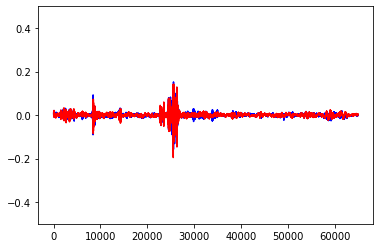

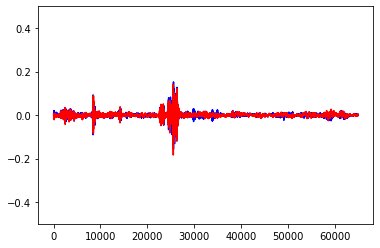

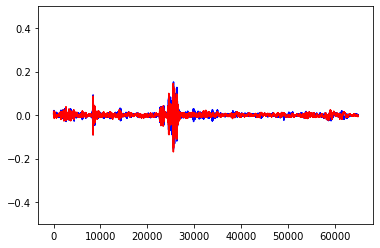

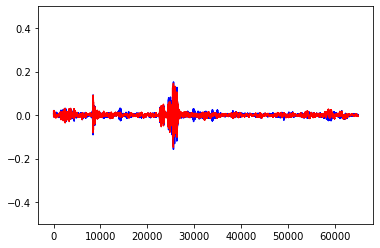

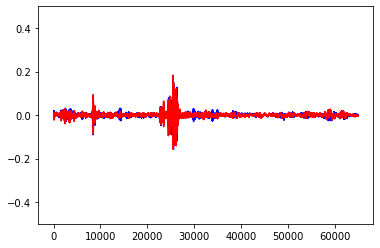

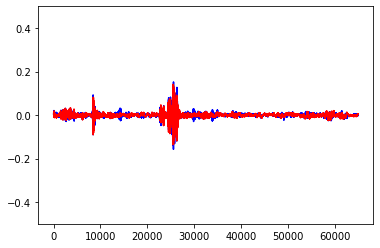

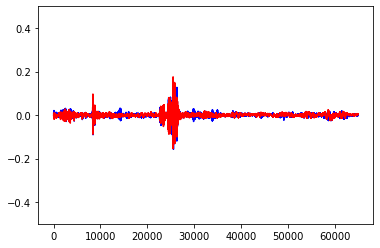

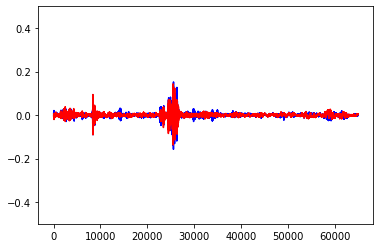

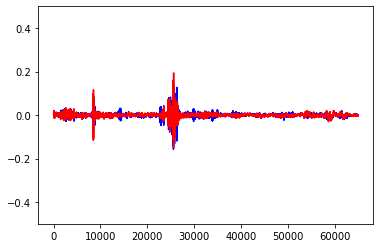

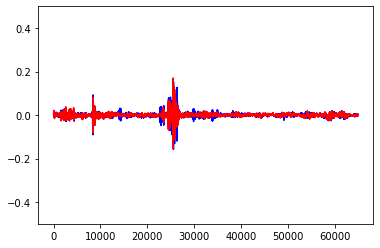

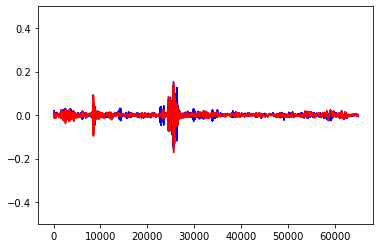

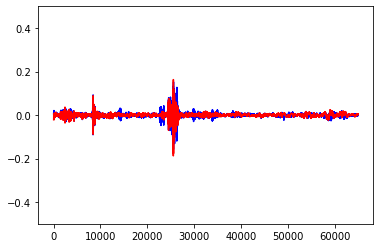

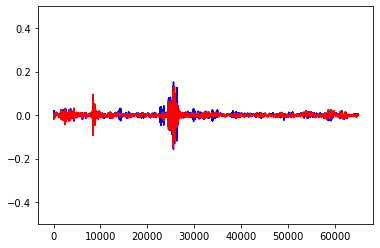

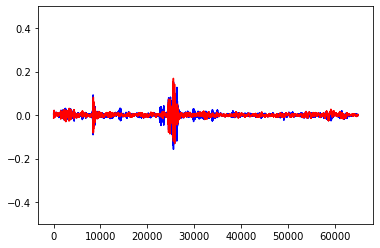

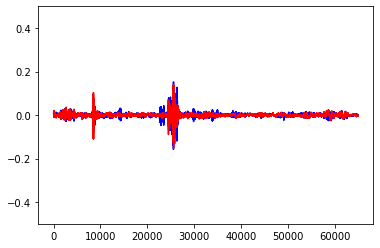

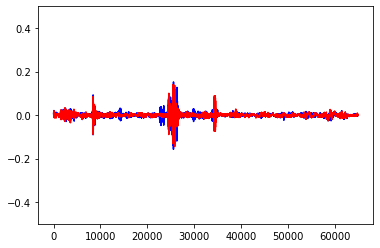

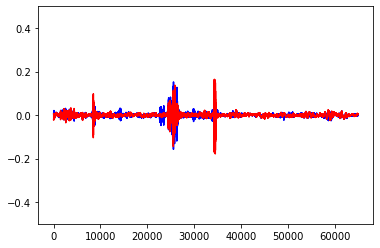

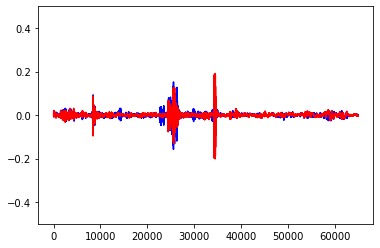

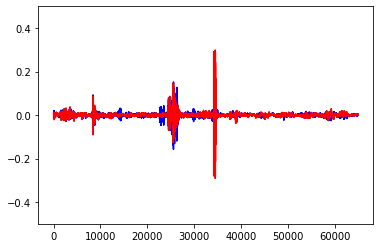

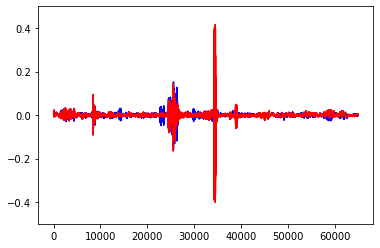

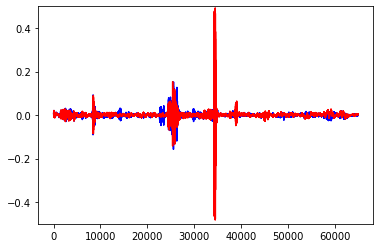

In [76]:
data_pth = op.join(proj_pth, 'examples/esc50/mag_seg15_256/')
wav_pth = op.join(proj_pth, 'examples/esc50/mag_seg15_256/loss_test_time_mask_only/audio')
output_pth = op.join(wav_pth, 'loss')
if op.isdir(output_pth) is False:
    os.mkdir(output_pth)
png_pth = op.join(wav_pth, 'png')
if op.isdir(png_pth) is False:
    os.mkdir(png_pth)
shape = ['square', 'time']
for filename in sorted(Path(data_pth).glob('*_res.wav')):
    #print(filename)
    origin_waveform, sr = torchaudio.load(filename, normalization=True)
    #print("Min: {}\nMax: {}\nMean: {}".format(origin_waveform.min(), origin_waveform.max(), origin_waveform.mean()))
    #plt.figure()
    #plt.plot(origin_waveform[0])
    file = op.basename(filename).split('.')[0].split('_origin')[0]
    for anyshape in shape:
        #print(file, anyshape)
        file_shape = file + '_' + anyshape
        #print(file_shape)
        error_list = []
        for output in tqdm(sorted(Path(wav_pth).glob(f'{file_shape}*.wav'))):
            #print(output)
            inpainted_waveform, sr = torchaudio.load(output, normalization=True)
            #print("Min: {}\nMax: {}\nMean: {}".format(inpainted_waveform.min(), inpainted_waveform.max(), inpainted_waveform.mean()))
            #plt.figure()
            #plt.plot(inpainted_waveform[0])
            #print(inpainted_waveform.shape, _, l)
            diff = torch.mean(abs(inpainted_waveform - origin_waveform))
            # err = ((origin_waveform-inpainted_waveform).abs() / origin_waveform.abs()).median()
            err_value = diff.item()
            error_list.append(err_value)
            # print(diff, err)
            
            wave_pack = np.concatenate((origin_waveform, inpainted_waveform), axis=0)
            # print(wave_pack.shape)
            
            plt.figure()
            plt.ylim(-0.5, 0.5)
            plt.plot(wave_pack[0], 'b', wave_pack[1], 'r')
            png_name = op.basename(output).split('.')[0] + '.png'
            png_name = op.join(png_pth, png_name)
            plt.savefig(png_name)
        error_filename = op.join(output_pth, f'{file_shape}_mean-l1.txt')
        with open(error_filename, 'w') as f:
            for index in error_list:
                f.write(str(index)+'\n')

In [74]:
print(origin_waveform, inpainted_waveform)
print(abs(origin_waveform - inpainted_waveform))
print(torch.mean(abs(origin_waveform - inpainted_waveform)))

tensor([[-0.0076, -0.0062, -0.0011,  ...,  0.0051, -0.0022, -0.0097]]) tensor([[ 0.0092,  0.0050, -0.0022,  ..., -0.0054, -0.0084, -0.0216]])
tensor([[0.0168, 0.0112, 0.0011,  ..., 0.0105, 0.0063, 0.0118]])
tensor(0.0291)


In [65]:
test_waveform = torch.tensor([[1., -1., .5, .5, .2, .1, 1.]])
test2_waveform = torch.tensor([[1.5, -1.5, 1.5, .5, .2, .1, 1.]])
print(test_waveform.shape, test2_waveform.shape)
print((test_waveform - test2_waveform).abs())
print(test_waveform.abs())
print((test_waveform - test2_waveform).abs() / test_waveform.abs())
print(((test_waveform - test2_waveform).abs() / test_waveform.abs()).median())
print(test_waveform.median())

torch.Size([1, 7]) torch.Size([1, 7])
tensor([[0.5000, 0.5000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
tensor([[1.0000, 1.0000, 0.5000, 0.5000, 0.2000, 0.1000, 1.0000]])
tensor([[0.5000, 0.5000, 2.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
tensor(0.)
tensor(0.5000)


In [ ]:
test_waveform = torch.tensor([[1., -1., .5, .5, .2, .1, 1.]])
test2_waveform = torch.tensor([[1.5, -1.5, 1.5, .5, .2, .1, 1.]])
print(test_waveform.shape, test2_waveform.shape)
print(abs(test_waveform - test2_waveform))
print(torch.mean(abs(test_waveform - test2_waveform)))

In [ ]:
'''
if op.isdir(output_pth) is False:
    os.mkdir(output_pth)
error_filename = op.join(output_pth, f'{file_shape}_mean-l1.txt')
with open(error_filename, 'w') as f:
    for index in error_list:
        f.write(str(index)+'\n')
'''